In [18]:
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [19]:
plt.rcParams['yaxis.labellocation'] = 'center'
plt.rcParams['xaxis.labellocation'] = 'center'
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rcParams['xtick.minor.top'] = False    # draw x axis top minor ticks
plt.rcParams['xtick.minor.bottom'] = False    # draw x axis bottom minor ticks
plt.rcParams['ytick.minor.left'] = True    # draw x axis top minor ticks
plt.rcParams['ytick.minor.right'] = True    # draw x axis bottom minor ticks
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['font.size'] = 16

In [20]:
total_num_samples = 455 # Replace with total number of training+evaluation samples
total_test_samples = 114 # Replace with total number of test samples

## Collect results

In [ ]:
base_dir = "results"  # Replace with your actual directory path
devices = ["cpu", "gpu"] # Replace with name of directories where results for each device are stored

# Initialize data storage
data = {device: {} for device in devices}

# Parse the directory structure
for device in devices:
    device_dir = os.path.join(base_dir, device)
    for bond_dir in os.listdir(device_dir):
        bond_path = os.path.join(device_dir, bond_dir)
        if not os.path.isdir(bond_path):
            continue
        
        bond_dim = int(bond_dir.split('_')[-1])

        if bond_dim == 400:
            continue

        train_times = []; train_times_per_batch = []
        throughputs = []; throughputs_test = []
        inference_times = []; inference_times_per_batch = []

        # Read parameters.txt
        params_file = os.path.join(bond_path, "execution_metrics.json")
        loss_file = os.path.join(bond_path, "loss.npy")
        if os.path.exists(params_file):
            with open(params_file, "r") as f:
                params = json.loads(f.read().split("Parameters: ")[-1])
                train_time_per_batch = float(params["train_time"])
                
                inference_times_perrun = ast.literal_eval(params['inference_times'])
                inference_time = np.mean(inference_times_perrun)
                inference_throughput = float(params["throughput"])
                batch_times = ast.literal_eval(params['batch_times'])
                batch_times = [float(x) for x in batch_times]

                
            throughput = 100 / train_time_per_batch
            
            train_times.append(train_time_per_batch)
            throughputs.append(throughput)
            throughputs_test.append(inference_throughput)
            inference_times.append(inference_time)
            train_times_per_batch.append(batch_times)

        # Initialization of dictionary
        if bond_dim not in data[device]:
            data[device][bond_dim] = {"train_time": [], "throughput": [], "throughput_inf": [], "inference_time": [], "train_time_per_batch": []}
        
        data[device][bond_dim]["train_time"] = train_times
        data[device][bond_dim]["throughput"] = throughputs
        data[device][bond_dim]["throughput_inf"] = throughputs_test
        data[device][bond_dim]["inference_time"] = inference_times
        data[device][bond_dim]["train_time_per_batch"] = train_times_per_batch
        

## Plot Throughput and Accuracy

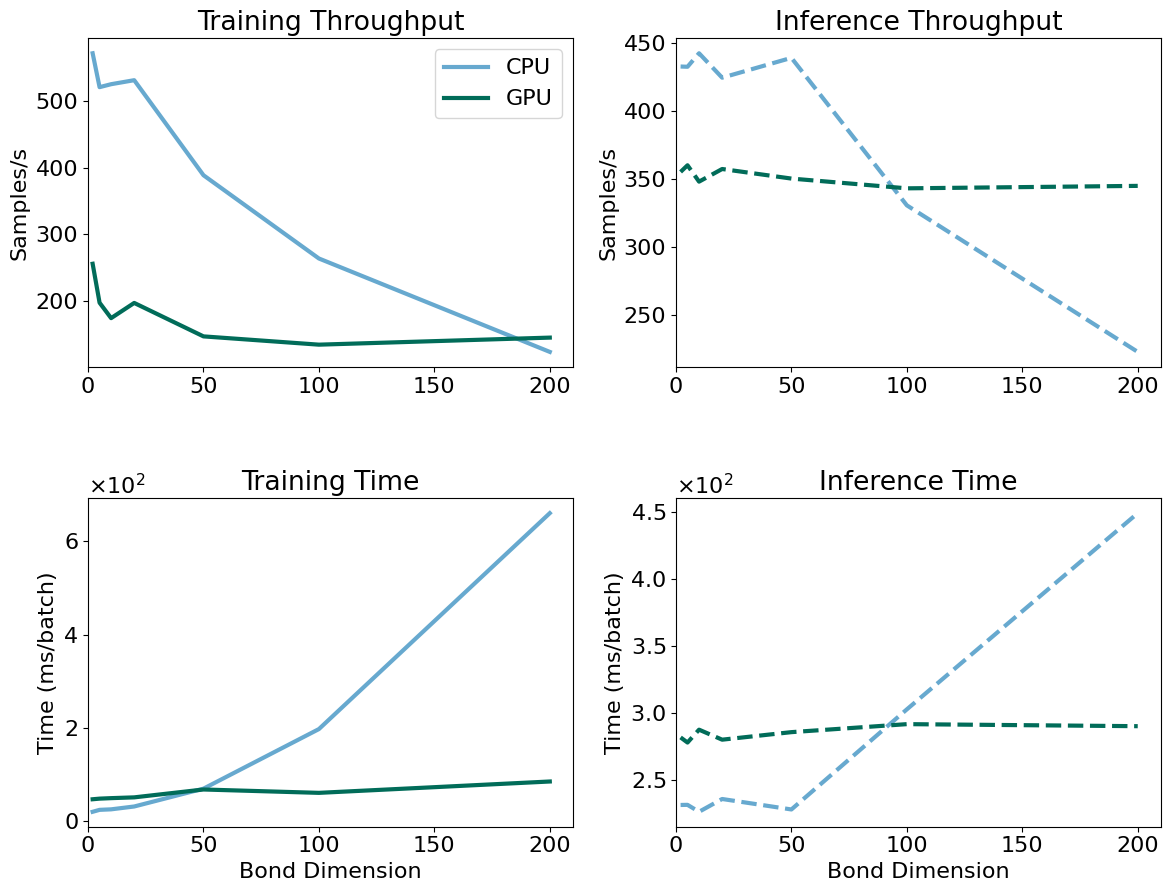

In [ ]:
from matplotlib.ticker import ScalarFormatter

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# Define colors for each device
colors = {'cpu': '#67a9cf', 'gpu': '#016c59'}

# --- Top Left: Training/Evaluation Throughput ---
ax = axs[0, 0]
for device in devices:
    bond_dims = sorted(data[device].keys())
    throughputs = [np.mean(data[device][bd]["throughput"]) for bd in bond_dims]
    ax.plot(bond_dims, throughputs, label=f'{device.upper()}', linewidth=3, color=colors[device])
ax.set_title("Training Throughput")
ax.get_xaxis().set_major_formatter(ScalarFormatter())  # Show raw numbers, not 10^x
ax.set_xlim(0, 210)
ax.set_ylabel("Samples/s")
ax.legend()

# --- Top Right: Inference Throughput (1 / time) ---
ax = axs[0, 1]
for device in devices:
    bond_dims = sorted(data[device].keys())
    inference_inv = [np.mean(data[device][bd]["throughput_inf"]) for bd in bond_dims]
    ax.plot(bond_dims, inference_inv, linestyle='--', linewidth = 3, label=f'{device.upper()}', color=colors[device])
ax.set_title("Inference Throughput")
ax.get_xaxis().set_major_formatter(ScalarFormatter())  # Show raw numbers, not 10^x
ax.set_xlim(0, 210)
ax.set_ylabel("Samples/s")
#ax.grid(True)

# --- Bottom Left: Training and Evaluation Time ---
ax = axs[1, 0]
for device in devices:
    bond_dims = sorted(data[device].keys())
    train_times = [np.mean(data[device][bd]["train_time_per_batch"]) * 1000 for bd in bond_dims]
    ax.plot(bond_dims, train_times, label=f'{device.upper()}', linewidth=3, color=colors[device])
ax.set_title("Training Time")
ax.set_xlabel("Bond Dimension")
ax.get_xaxis().set_major_formatter(ScalarFormatter())  # Show raw numbers, not 10^x
ax.set_xlim(0, 210)
ax.set_ylabel("Time (ms/batch)")

# Force scientific notation with 10^3
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always show scientific notation
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# --- Bottom Right: Inference Time with Error Bars ---
ax = axs[1, 1]
for device in devices:
    bond_dims = sorted(data[device].keys())
    means = [np.mean(data[device][bd]["inference_time"]) * 1000 for bd in bond_dims]
    stds = [np.std(data[device][bd]["inference_time"]) for bd in bond_dims]
    ax.plot(bond_dims, means, linestyle='--', linewidth=3, label=f'{device.upper()}', color=colors[device])
ax.set_title("Inference Time")
ax.set_xlabel("Bond Dimension")
ax.get_xaxis().set_major_formatter(ScalarFormatter())  # Show raw numbers, not 10^x
ax.set_xlim(0, 210)
ax.set_ylabel("Time (ms/batch)")

# Apply same formatting
formatter2 = ScalarFormatter(useMathText=True)
formatter2.set_powerlimits((0, 0))
ax.yaxis.set_major_formatter(formatter2)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.4)  # Increase this value for more space vertically
plt.savefig("evaluation_metrics.pdf", dpi=300)

/var/folders/cc/j3fcvpsj3097_lc2q00x2v1h0000gn/T/ipykernel_31646/2665834248.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 450)


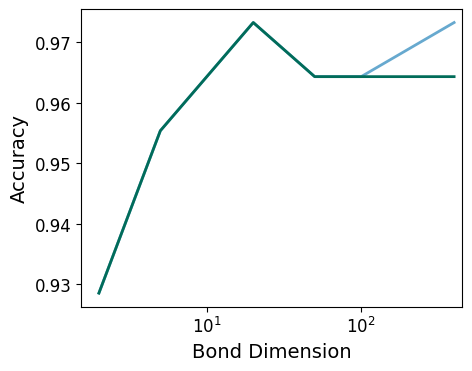

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
colors = {'cpu': '#67a9cf', 'gpu': '#016c59'}

for device in devices:
    bond_dims = sorted(data[device].keys())
    bond_dims = [bd for bd in bond_dims if bd != 200]
    accuracies = [np.mean(data[device][bd]["acc"]) for bd in bond_dims]

    ax.plot(bond_dims, accuracies, label=device.upper(), linewidth=2, color=colors[device])

ax.set_xscale("log")
ax.set_xlabel("Bond Dimension", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks(bond_dims)
ax.set_xticklabels(bond_dims)
ax.set_xlim(0, 450)
ax.legend(fontsize=12, loc="best")

plt.tight_layout()
plt.savefig('accuracy_vs_bond_dimension_breast_class.pdf', dpi=300)

